# バイアス-バリアンスの分解と、アンサンブルの話。

In [1]:
from functools import partial
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

$$
\def\calD{\mathcal{D}}
\def\paren#1{\left(#1\right)}
\def\brac#1{\left[#1\right]}
\def\quad#1{\paren{#1}^2}
\def\sumi{\sum_{i=1}^N}
\def\sumk{\sum_{k=1}^K}
\def\E#1{\mathbb{E}_{\calD}\brac{#1}}
\def\var#1{\mathrm{Var}_{\calD}\brac{#1}}
\def\cov#1{\mathrm{Cov}_{\calD}\brac{#1}}
\def\bias#1{\mathrm{Bias}_{\calD}\brac{#1}}
\def\hf{\hat{f}_{\calD}}
\def\hfk{\hf^k}
\def\fx{f(x^*)}
\def\hfx{\hf(x^*)}
\def\hfkx{\hfk(x^*)}
\def\Ehfx{\E{\hfx}}
\def\Ehfkx{\E{\hfkx}}
\def\mse{\mathrm{MSE}_{\calD}}
\def\ss{\sigma^2_*}
\def\cc{\sigma_{**}}
$$

# バイアスとバリアンスの分解
$J$個の説明変数を$X = (X_1, \dots, X_J)$、目的変数を$Y$とします。
真の関数形は$f(x)$で、目的変数はこれにノイズ$U$が乗って観測されるとします。

$$
\begin{align}
    Y_i = f(X_i) + U_i 
\end{align}
$$

$N$個の観測されたデータの組を$\calD = \{(X_i, Y_i)\}_{i=1}^N$とします。
適当なアルゴリズムを使って、データ$\calD$を学習して予測モデル$\hf(x)$を構築します。
得られた予測モデルを用いて新しいデータ$x^*$に対する予測を行います。
真の値$\fx$と比べてこの予測値$\hfx$がどのくらいずれるのかがこの記事の興味の対象になります。

予測誤差は二乗誤差で評価することにします。
観測データはサンプリングされたものなので、データ$\calD$のばらつき応じて学習済みモデルも変動し、予測値も変わるはずです。
そこで、二乗誤差の期待値をとることにし、これを平均二乗誤差（MSE)と呼ぶことにします。
このとき、新しいデータ$x^*$に対するMSEは以下で表現できます。

$$
\begin{align}
    \mse(x^*) = \E{\quad{\fx - \hfx}}
\end{align}
$$

ここで、何に対して期待値をとっているかを明示的にするため$\E{\cdot}$という表記を用いています。

実は、MSEはモデルの偏り（バイアス）とモデルの安定性（バリアンス）に分解できることが知られています。
バイアスとバリアンスの正確な定義は後ほど触れます。
まず、$\Ehfx$を足して引くことでMSEを3つのパートに分解できます。

$$
\begin{align}
    \mse(x^*) 
    =& \E{\quad{\fx - \Ehfx - \paren{\hfx - \Ehfx}}}\\
    =& \E{\quad{\fx - \Ehfx}} \\
    &- \E{2\paren{\fx - \Ehfx}\paren{\hfx - \Ehfx}} \\
    &+ \E{\quad{\hfx - \Ehfx}}
\end{align}
$$

ここで、$\fx$とか$\Ehfx$は確率変数ではなく確定的な値なので期待値の外に出せます。
$$
\begin{align}
    \mse(x^*) 
    =& \quad{\fx - \Ehfx} \\
    &- 2\paren{\fx - \Ehfx}\paren{\Ehfx - \Ehfx} \\
    &+ \E{\quad{\hfx - \Ehfx}}
\end{align}
$$

第二項は0になるので、残りは第一項と第三項です。
これらはそれぞれバイアスとバリアンスと呼ばれています。

$$
\begin{align}
    \bias{\hfx} &= \fx - \Ehfx, \\
    \var{\hfx} &= \E{\quad{\hfx - \Ehfx}}
\end{align}
$$


バリアンスはモデルの予測値$\Ehfx$が訓練データの影響を受けてどのくらいばらつくのかを表す指標です。
僕たちが観測するデータは母集団からのサンプリングなので、仮想的に何度もサンプリングを行うと毎回少し違うデータが観測されるわけですが、そのデータが少し違うことに対してどのくらい予測値が安定的かがバリアンスに反映されます。
ちょっと違うデータが与えられたときにモデルの予測が大きく異なるならバリアンスは大きく、逆にデータが変動しても似たような予測値を返すならバリアンスは小さくなります。

一方で、バイアスはモデルの予測の期待値$\Ehfx$が、真の値$\fx$からどのくらいずれるのかを表す指標です。
ここで、あくまで期待値の意味でのずれに焦点があたっていることに注意してください。
例えば、バリアンスの大きいモデルは、仮想的に何度もサンプリングを行う状況を考えると毎回違う予測値を出しますが、それを平均すると真の値$\fx$と近くなっているのか？ということをバイアスは測定していると解釈できます。


元の式に戻ると、MSEはバイアス（の二乗）とバリアンスに分解できることがわかります。

$$
\begin{align}
    \mse(x^*) = \bias{\hfx}^2 + \var{\hfx}
\end{align}
$$

この分解はバイアス-バリアンス分解（bias-variance decomposition）と呼ばれています。

一般に、モデルが単純な場合はバリアンスが小さい代わりにバイアスが大きくなります。
一方で、モデルが複雑な場合はバイアスが小さい代わりにバイアスが大きくなります。
このように、バイアスとバリアンスにはトレードオフが存在し、これはbias-variance tradeoffと呼ばれています。
MSEはバイアスとバリアンスの足し算で決まるので、バイアスとバリアンスがいい塩梅になるようにモデルの複雑さを決めることが予測精度の高いモデルを構築する際には重要です。

なお、上記で計算したMSEはある入力$x^*$に対するものなので、もし平均的な予測誤差を知りたい場合は

$$
\begin{align}
   \mathbb{E}_{X^*}\brac{{\mse(X^*)}}
\end{align}
$$

のように入力の確率分布を用いて期待値をとる必要があることに注意してください。

# シミュレーションでバイアスとバリアンスの関係を確認する
## シミュレーションの設定

以下の設定でシミュレーションデータを生成します。
$$
\begin{align}
    Y &= \sin(6 \pi X) + U,\\
    X &\sim \mathrm{Uniform}(0, 1),\\
    U &\sim \mathcal{N}(0, 1)
\end{align}
$$

ここで、説明変数$X$は区間$[0, 1]$の一様分布から生成します。
$X$にsin関数を噛ませて、ノイズ$U$を乗せて目的変数としています。
ノイズ$U$は平均0、分散1の正規分布から生成します。

この設定で、データを生成してモデルを学習し予測する、ということを何回も繰り返して、モデルのバイアスとバリアンスを確認することにします。
シミュレーションを行いその結果を可視化するために以下の`Simulator`クラスを実装しました。

In [3]:
@dataclass
class Simulator:
    """シミュレーションとその結果の可視化を行うクラス

    Args:
        n_grids: Xの理論値をどのくらい細かく作成するか
    """

    n_grids: int = 100

    def __post_init__(self) -> None:
        """理論値を作成"""

        # シミュレーションの関数形を特定
        self.f = lambda X: np.sin(6 * np.pi * X)

        # Xの範囲をグリッドで分割
        self.X_theory = np.linspace(start=0, stop=1, num=self.n_grids)

        # f(X)で理論値を作成
        self.y_theory = self.f(self.X_theory)

    def generate_simulation_data(
        self, n_instances: int
    ) -> tuple[np.ndarray, np.ndarray]:
        """シミュレーション用のデータを生成する

        Args:
            n_instances: シミュレーションで生成するインスタンスの数
        Returns:
            特徴量と目的変数のtuple
        """

        # Xは一様分布から、yは正規分布から生成する
        X = np.random.uniform(low=0, high=1, size=n_instances)
        u = np.random.normal(loc=0, scale=1, size=n_instances)
        # 関数f(X)を噛ませてノイズを足して目的変数とする
        y = self.f(X) + u

        return (X, y)

    def simulate(
        self, estimators: dict[str, Any], n_simulations: int, n_instances: int
    ) -> dict[str, np.ndarray]:
        """シミュレーションデータを生成して、学習と予測を行う

        Args:
            estimators: シミュレーション用のモデル
            n_simulations: シミュレーション回数
            n_instances: シミュレーションで生成するインスタンスの数
        Returns:
            モデルごとの予測値がまとまった辞書
        """

        y_preds = {
            k: np.zeros((self.n_grids, n_simulations)) for k in estimators.keys()
        }
        for s in range(n_simulations):
            X, y = self.generate_simulation_data(n_instances)
            for k, estimator in estimators.items():
                y_preds[k][:, s] = estimator.fit(X.reshape(-1, 1), y).predict(
                    self.X_theory.reshape(-1, 1)
                )

        return y_preds

    def decompose_bias_variance(
        self,
        y_preds: dict[str, np.ndarray],
    ) -> dict[dtr, dict[str, np.ndarray]]:
        """バイアスとバリアンスに分解する
        
        Args:
            y_preds: モデルごとの予測値
        Returns:
            BiasとVarianceがまとまった辞書
        """

        bias = {
            k: (self.y_theory - y_pred.mean(axis=1)) ** 2
            for k, y_pred in y_preds.items()
        }
        variance = {k: y_pred.var(axis=1) for k, y_pred in y_preds.items()}

        return {"Bias2": bias, "Variance": variance}

    def draw_prediction(
        self,
        y_preds: dict[str, np.ndarray],
        estimator_key: int,
        simulation_ids: list[int],
        ylim: tuple(float, float) | None = None,
    ) -> None:
        """予測結果を可視化

        Args:
            y_preds: 予測結果
            estimator_key: 可視化したいモデルの名前
            simulation_ids: 何回目のシミュレーション結果を可視化するか
            ylim: グラフの上限下限を調整したいときに使う
        """

        if ylim is None:
            y = np.concatenate([y for y in y_preds.values()])
            ylim = (y.min(), y.max())

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

        # バイアスの可視化
        axes[0].plot(
            self.X_theory,
            y_preds[estimator_key].mean(axis=1),
            linewidth=2,
            label=f"予測値（シミュレーションの平均）",
        )
        axes[0].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")
        axes[0].legend()
        axes[0].set(xlabel="X", ylabel="Y", ylim=ylim, title="Biasの可視化")

        # バリアンスの可視化
        axes[1].plot(self.X_theory, self.y_theory, color=".3", linewidth=2, label="理論値")

        for s in simulation_ids:
            axes[1].plot(
                self.X_theory,
                y_preds[estimator_key][:, s],
                linewidth=0.1,
                color=sns.color_palette()[0],
                label=f"予測値（シミュレーション{s:02.0f}）",
            )
        axes[1].set(xlabel="X", ylabel="Y", ylim=ylim, title="Varianceの可視化")

        fig.suptitle(f"{estimator_key}のBiasとVarianceを可視化")
        fig.show()

    def draw_bias_variance(
        self, bias_variances: dict[str, dict[str, np.ndarray]]
    ) -> None:
        """バイアスとバリアンスを可視化する

        Args:
            bias_variances: decompose_bias_variance()の結果
        """

        fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
        for ax, (k, bvs) in zip(axes, bias_variances.items()):
            for estimator_key, value in bvs.items():
                # Xは一様分布に従うので単に平均をとればいい
                avg = value.mean()
                ax.plot(
                    self.X_theory,
                    value,
                    linewidth=1,
                    label=f"{estimator_key}(AVG:{avg: .2f})",
                )
                ax.legend()
                ax.set(xlabel="X", title=k)
        fig.suptitle(f"モデルごとのBias-Varianceの比較")
        fig.show()

## シミュレーション結果の確認

予測モデルとしては取り扱いの簡単さを重視して決定木を採用することにします。
ハイパーパラメータ`max_depth`を調整することでモデルの複雑さを簡単に制御することができます。

`max_depth`は決定木の最大分割回数を制御するハイパーパラメータで、例えば、`max_depth=1`なら決定木は一度しか分割を行わないので、2種類の予測値しか出しません。
この場合、モデルが非常に単純なので、バイアスが大きくバリアンスが小さくなることが予測されます。
一方で、`max_depth=10`なら最大で2の10乗つまり1024種類の予測値を出せることになります。
この場合は`max_depth=1`よりもモデルが複雑になるので、バイアスが小さくバリアンスが大きくなるでしょう。

それでは、実際に`max_depth=1`と`max_depth=10`の決定木でシミュレーションを行います。
シミュレーションの回数は100回、一回のシミュレーションで生成するインスタンスの数は1000とします。

In [4]:
# シミュレーターインスタンスの作成
simulator = Simulator()

# 単純なモデルと複雑なモデルを用意
dts = {
    "DecisionTree(01)": DecisionTreeRegressor(max_depth=1),
    "DecisionTree(10)": DecisionTreeRegressor(max_depth=10),
}

# 予測結果
y_preds = simulator.simulate(estimators=dts, n_simulations=100, n_instances=1000)

# バイアスとバリアンスに分解
bias_variances = simulator.decompose_bias_variance(y_preds)

まずは、単純な`max_depth=1`の場合を確認します。
モデルはsin関数の波をまともに捉えられておらず、バイアスが大きいことがわかります。
一方で、どのシミュレーションでも左端で分割するか右端で分割するかの2択がばらついているだけでほぼ同じような予測を行っており、バリアンスは小さいことが見て取れます。

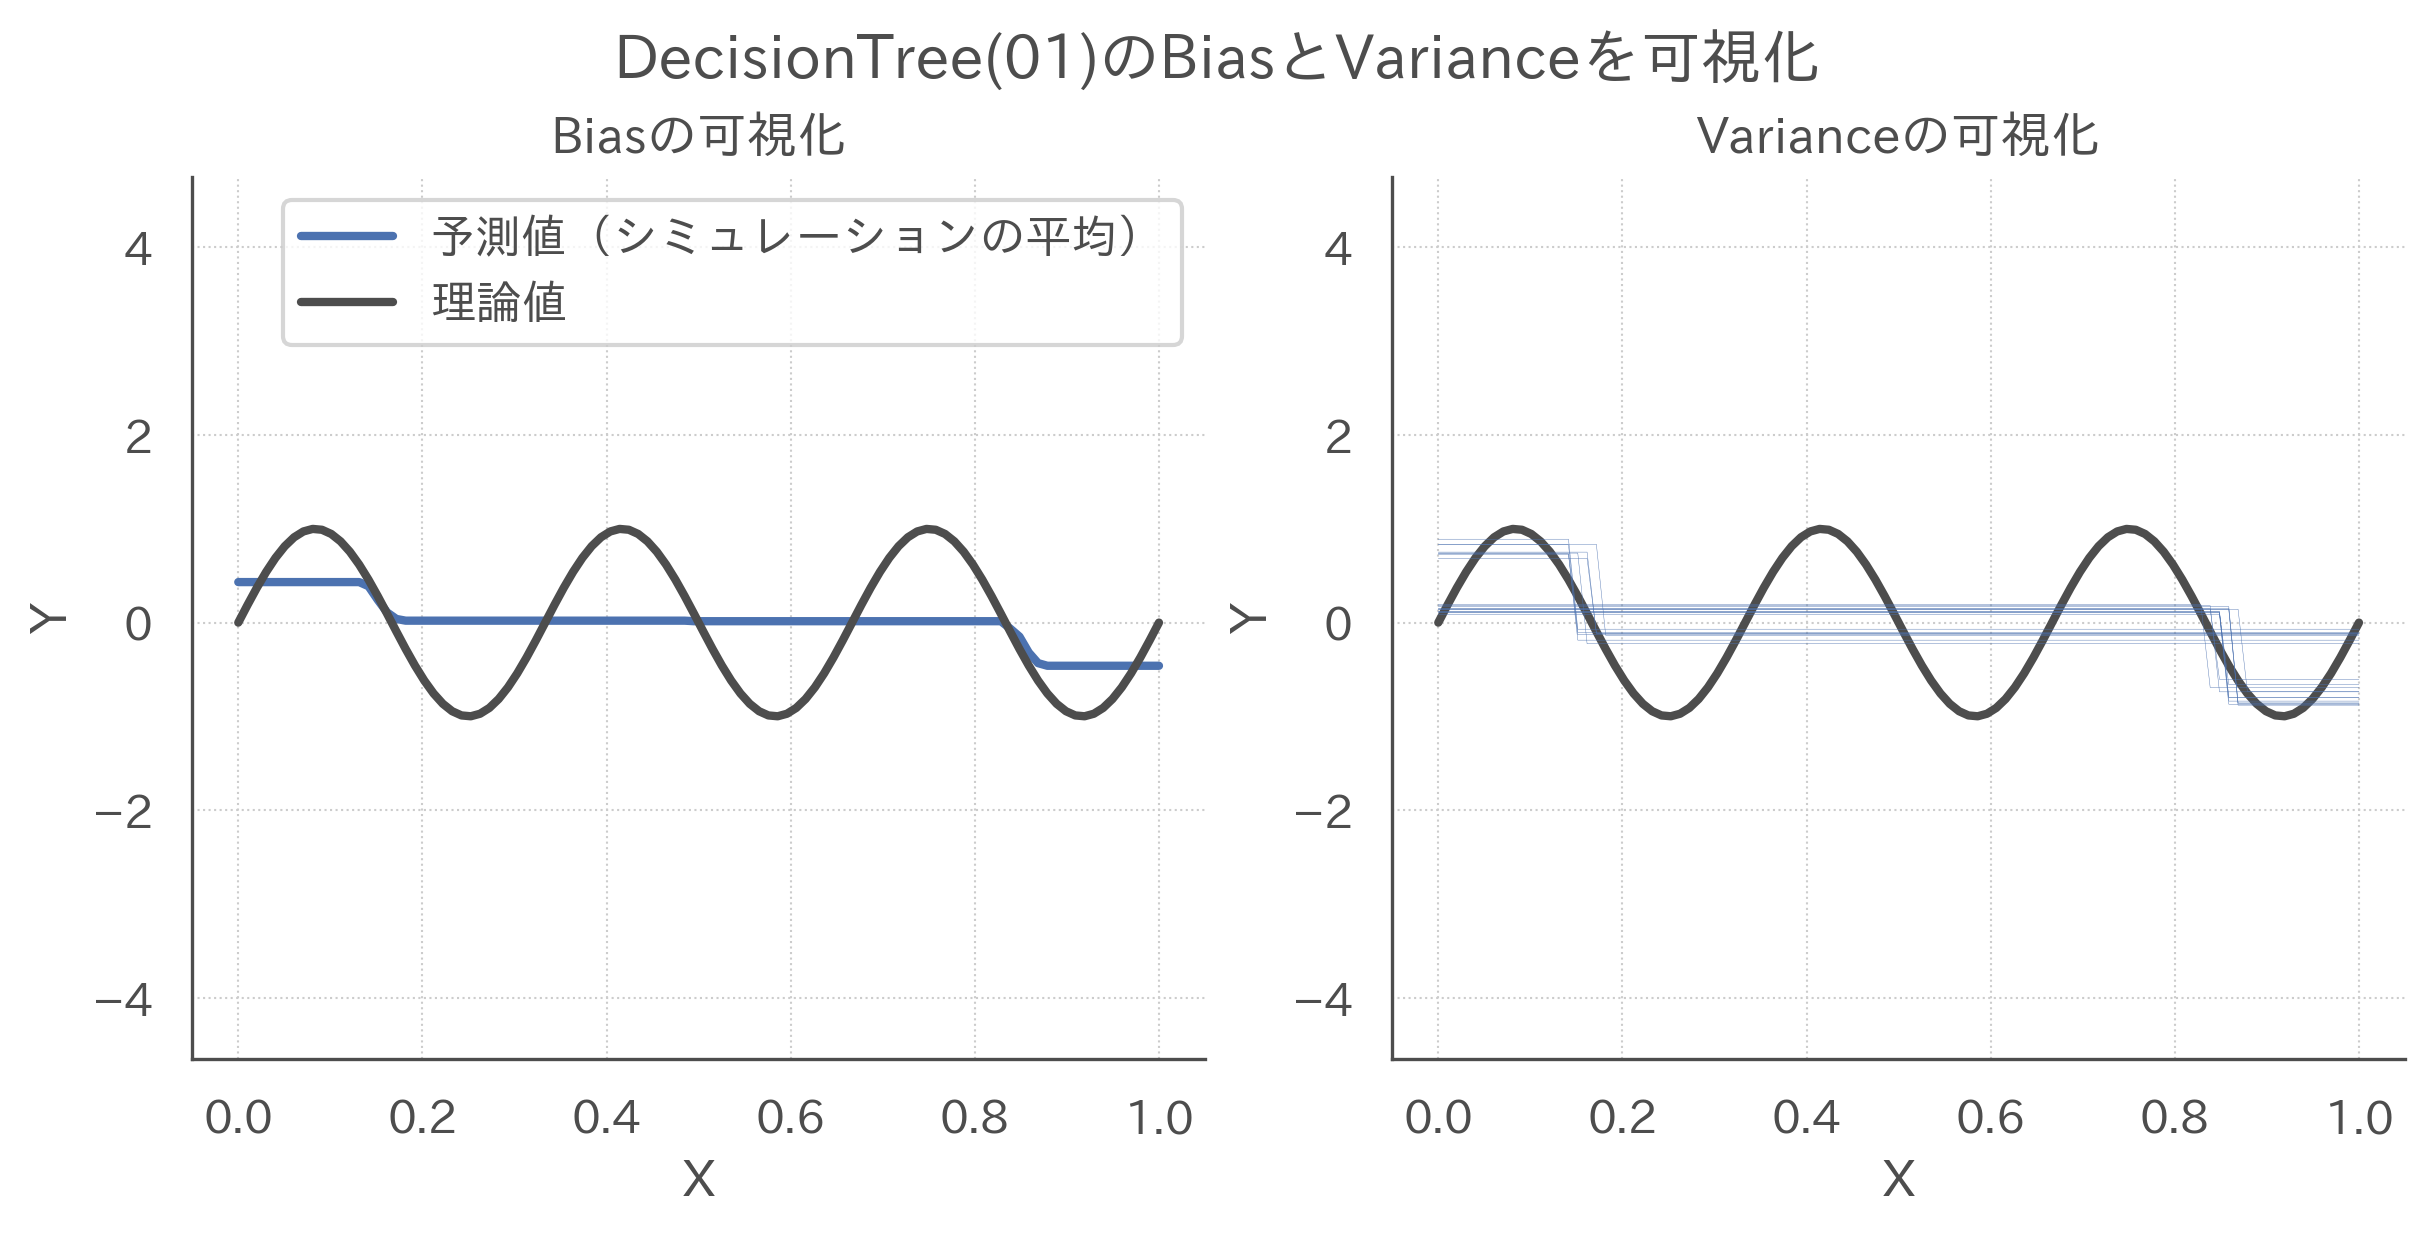

In [5]:
# 単純なモデルの予測結果を可視化
# シミュレーション結果をすべて可視化するとうるさいので20個にしぼる
simulator.draw_prediction(
    y_preds=y_preds, simulation_ids=range(20), estimator_key="DecisionTree(01)"
)

次に、複雑な`max_depth=10`の場合を確認します。
モデルは（平均的には）sin関数の波を十分に捉えることができており、バイアスが小さいことがわかります。
一方で、シミュレーションごとに予測値はかなり荒れており、バリアンスは大きいことが見て取れます。

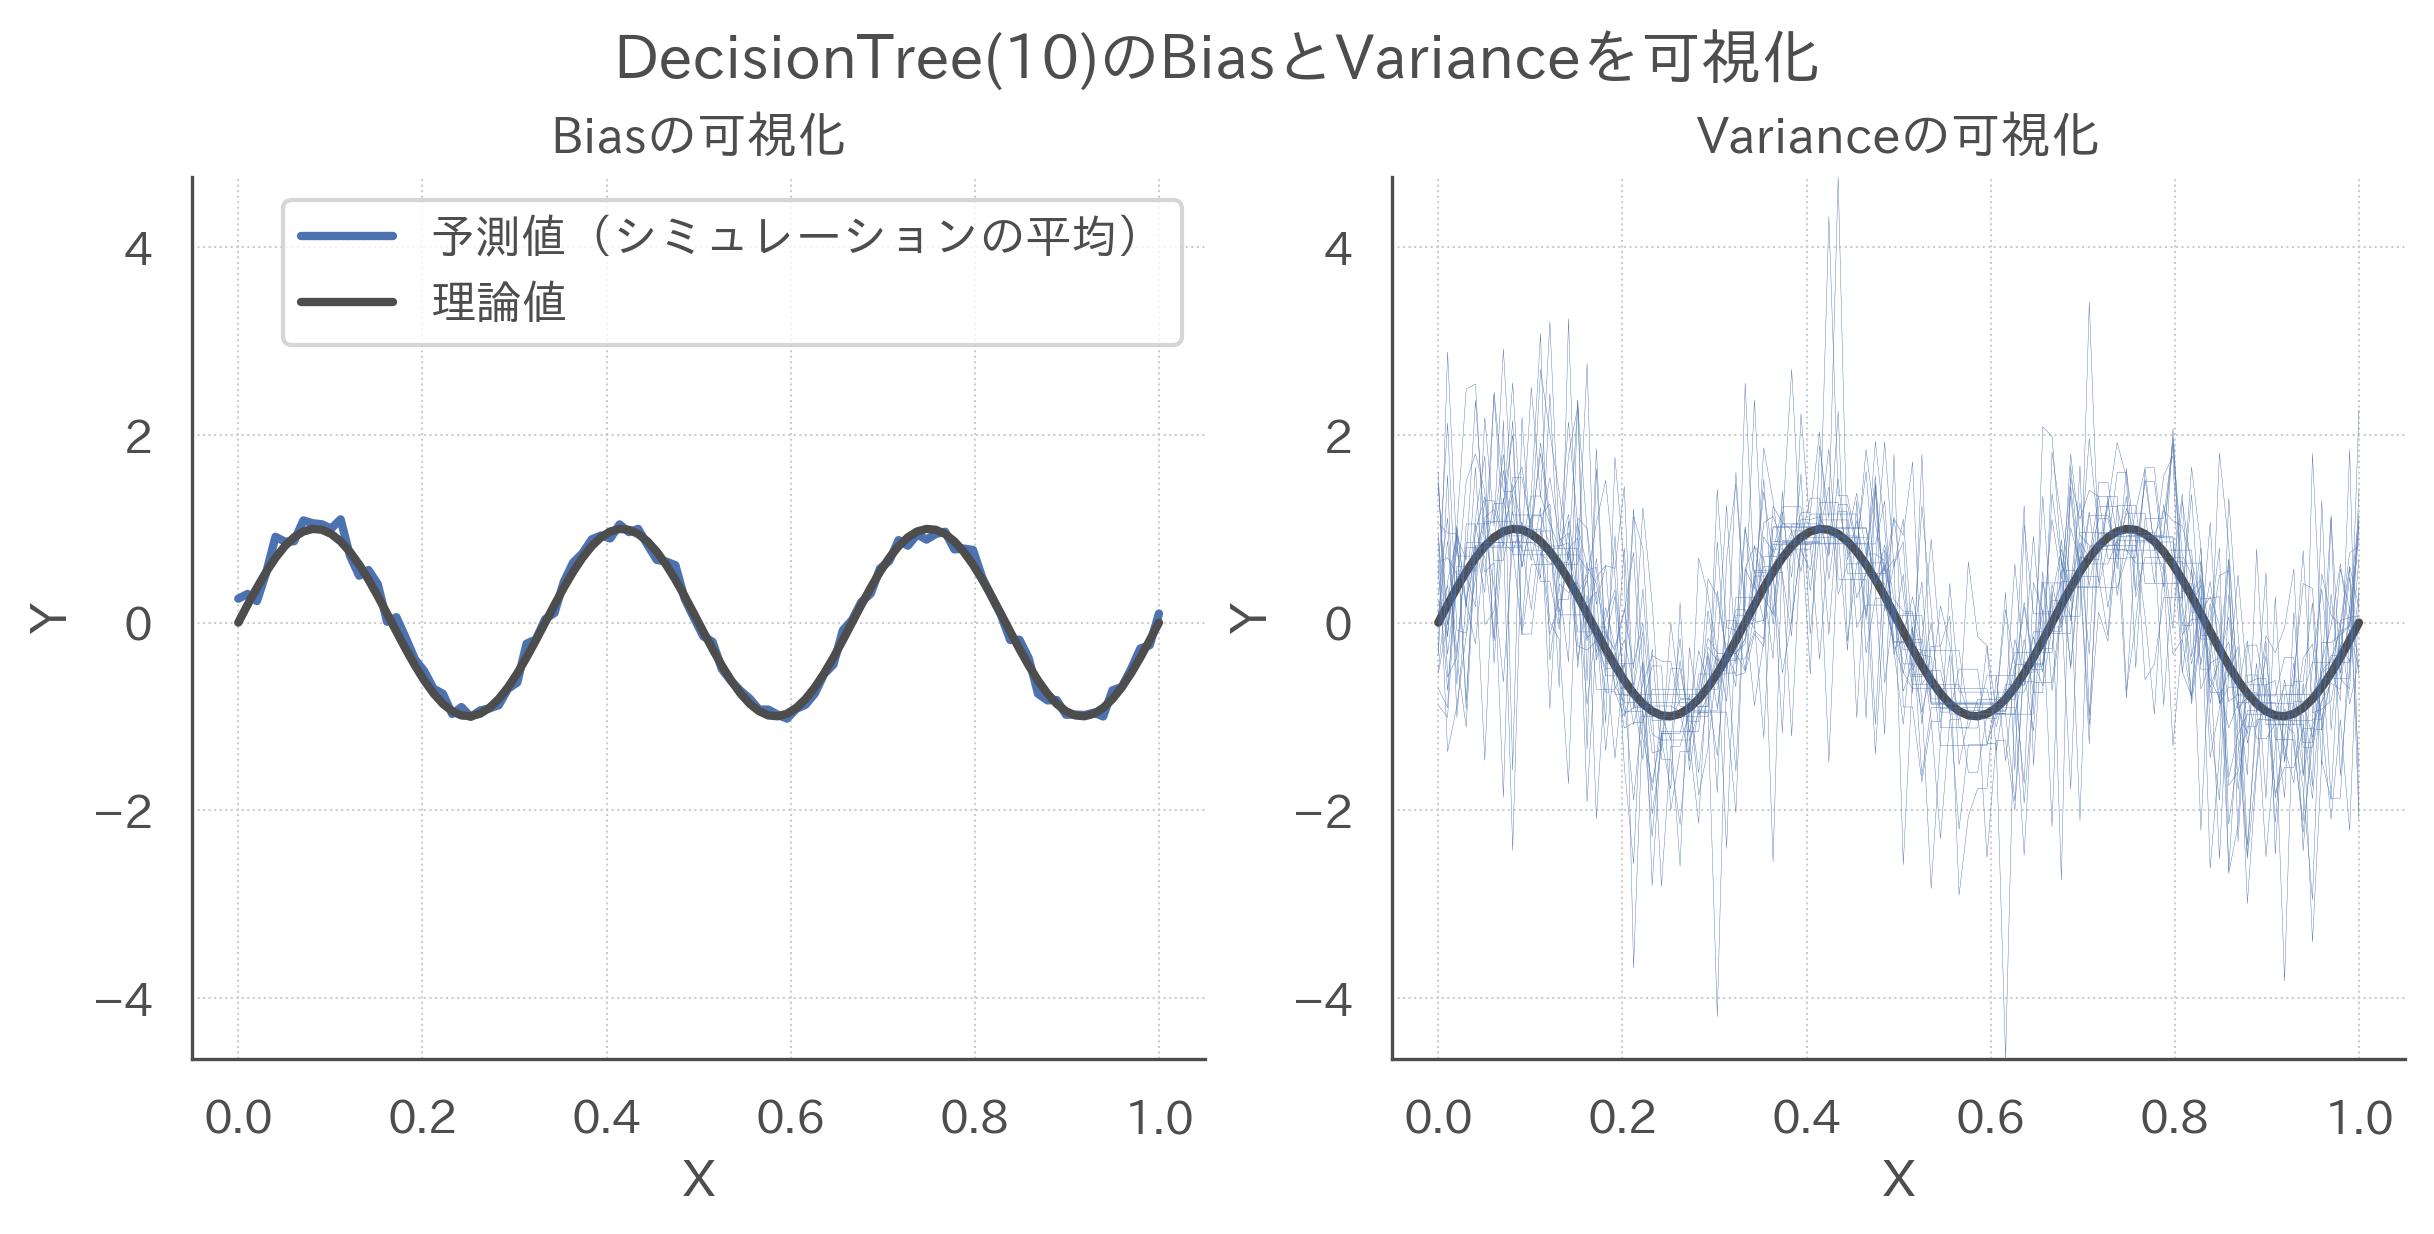

In [6]:
# 複雑なモデルの予測結果を可視化
simulator.draw_prediction(
    y_preds=y_preds, simulation_ids=range(20), estimator_key="DecisionTree(10)"
)

モデルごとにバイアス（の二乗）とバリアンスを直接比較したグラフが下図になります。
単純な`max_depth=1`のモデルはバイアスが大きい反面バリアンスが小さく、複雑な`max_depth=10`のモデルはバイアスが小さい反面バリアンスが大きいことが見て取れます。
このように、シミュレーション結果はモデルのバイアスとバリアンスにはトレードオフがあることを示唆しています。

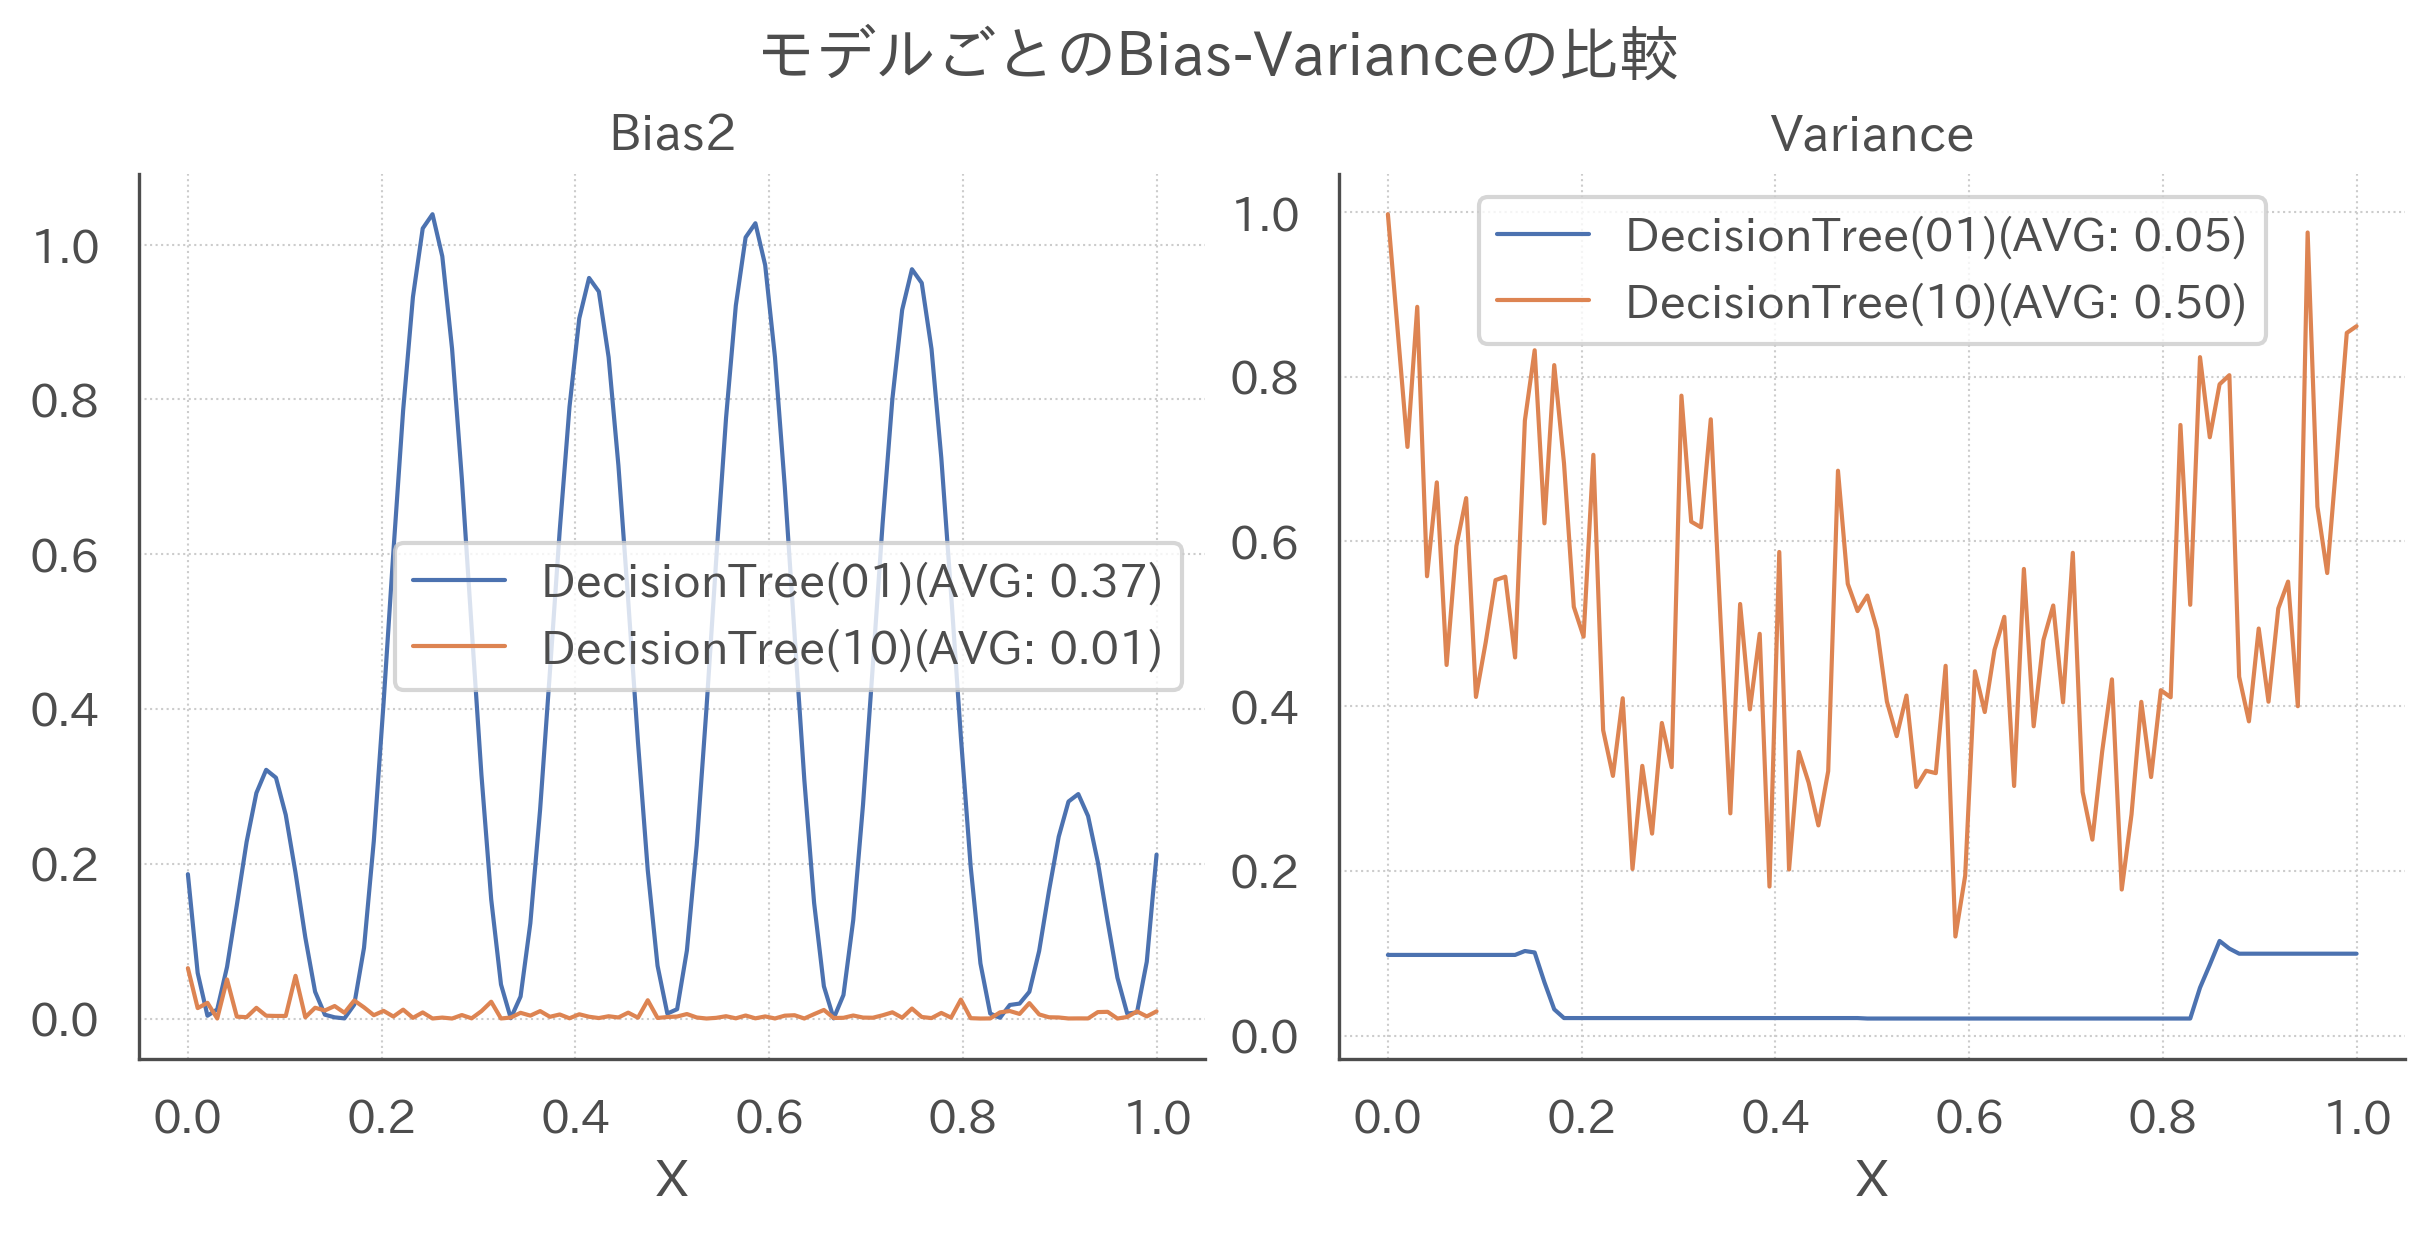

In [7]:
# モデルごとのバイアスとバリアンスを比較
simulator.draw_bias_variance(bias_variances=bias_variances)

## バイアスとバリアンスのトレードオフを可視化する

単純なモデルと複雑なモデルにはバイアスとバリアンスのトレードオフがあることが示唆されました。
このトレードオフをより詳細に確認するため、`max_depth`を1から10まで変化させた際にバイアスとバリアンスがどのように変化するかを追跡しましょう。

In [8]:
# max_depth`を1から10まで変化させる
max_depth_range = list(range(1, 11))
dts = {f'DT({x:02})': DecisionTreeRegressor(max_depth=x) for x in max_depth_range}

# 予測値を作成
y_preds = simulator.simulate(estimators=dts, n_simulations=100, n_instances=1000)

# バイアスとバリアンスを分解
bias_variances = simulator.decompose_bias_variance(y_preds)

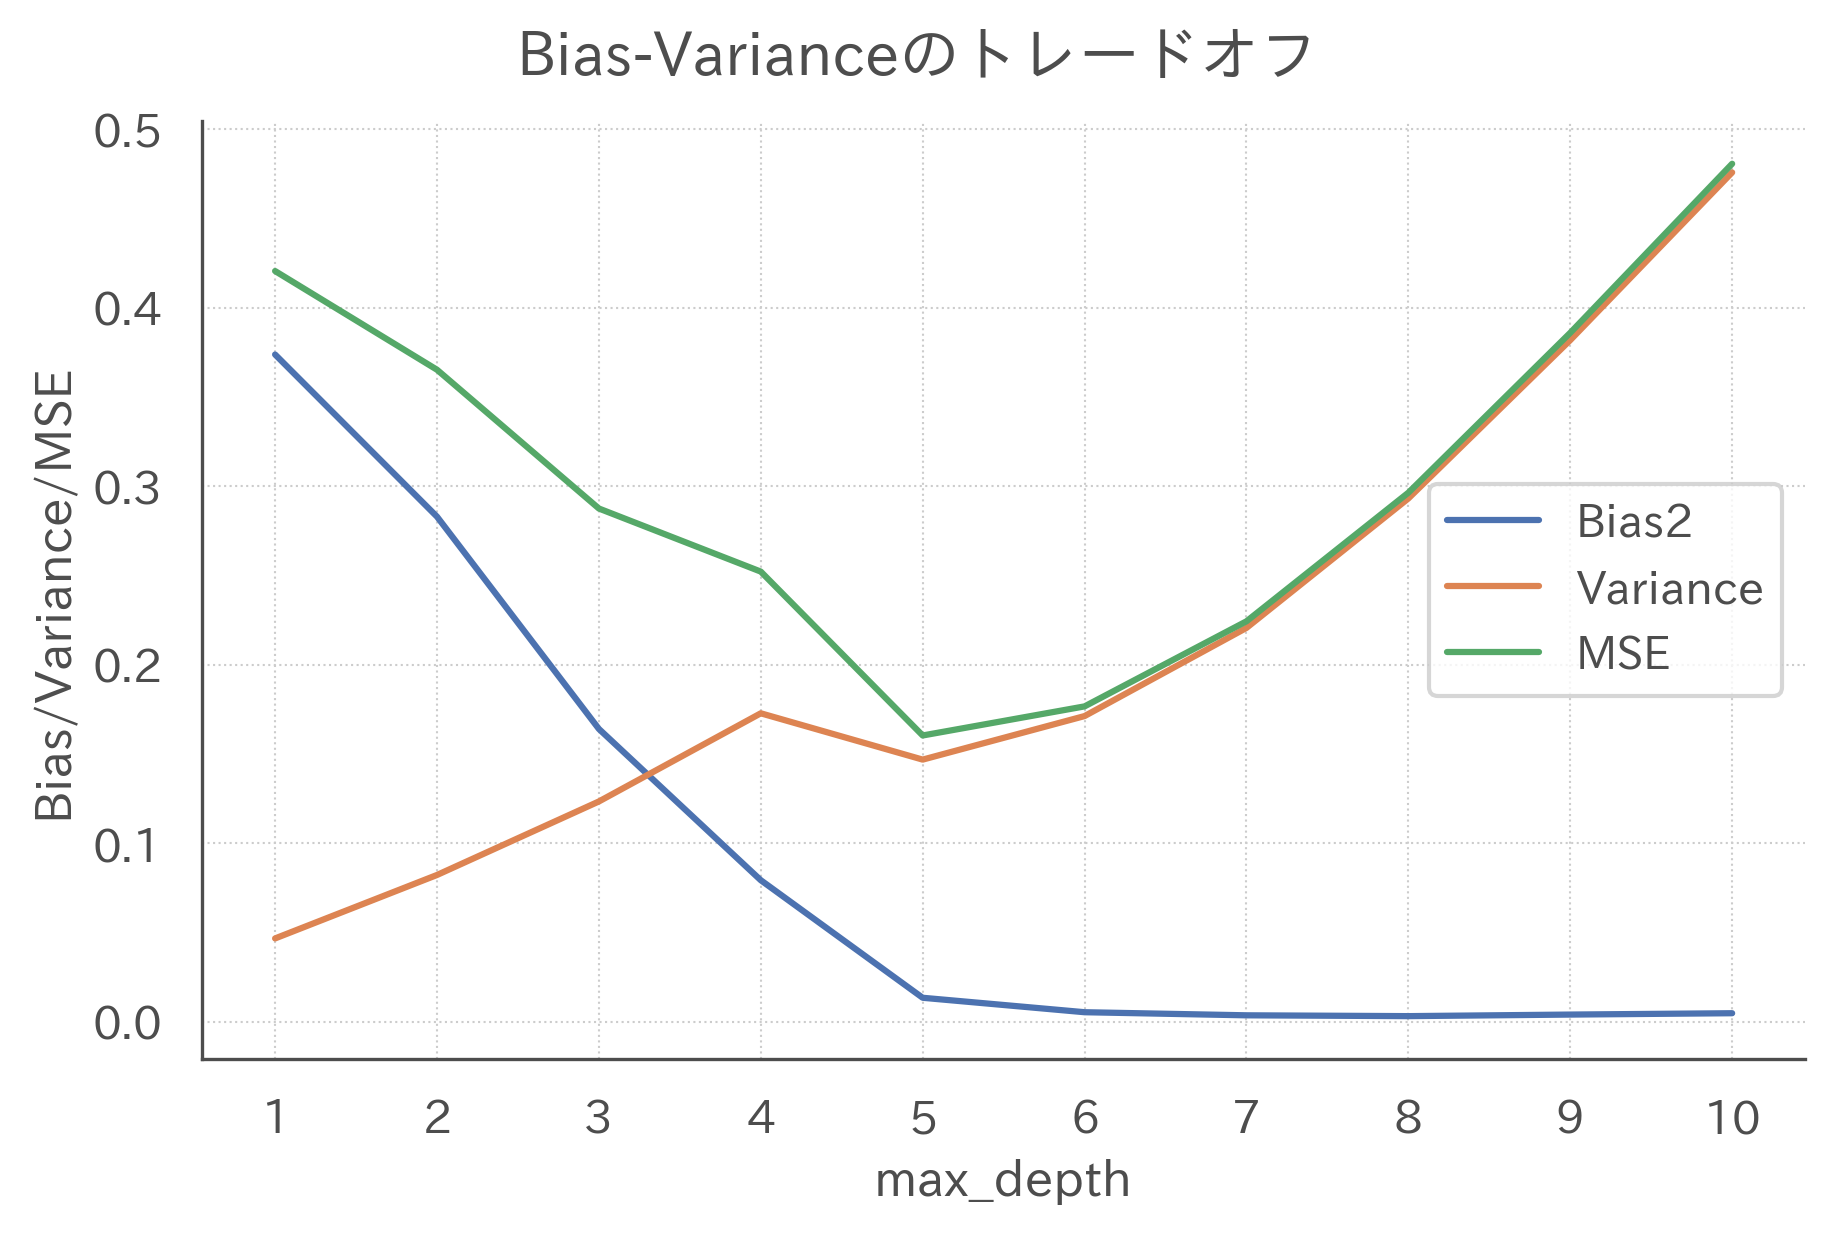

In [9]:
def draw_bias_variance_tradeoff(
    bias_variances: dict[str, dict[str, np.ndarray]], max_depth_range: list
) -> None:
    """max_depthを変化させた際のバイアスとバリアンスの可視化"""

    bias = np.array([v.mean() for v in bias_variances["Bias2"].values()])
    variance = np.array([v.mean() for v in bias_variances["Variance"].values()])
    mse = bias + variance

    fig, ax = plt.subplots()
    ax.plot(max_depth_range, bias, label="Bias2")
    ax.plot(max_depth_range, variance, label="Variance")
    ax.plot(max_depth_range, mse, label="MSE")
    ax.legend()
    ax.set_xticks(max_depth_range)
    ax.set(xlabel="max_depth", ylabel="Bias/Variance/MSE")
    fig.suptitle("Bias-Varianceのトレードオフ")
    fig.show()


draw_bias_variance_tradeoff(bias_variances, max_depth_range)

モデルを複雑にするつれてバイアスが小さくなる反面バリアンスが大きくなっていく様子が見て取れます。
また、MSEはバイアスの二乗とバリアンスの足し算なので、最も理論値との誤差が小さくなるいい塩梅のハイパーパラメータは`max_depth=5`であることがわかります。

# モデルのアンサンブルでばらつきを抑える

ここまで、バイアスとバリアンスにはトレードオフがあることを見てきました。
モデルを複雑にすればバイアスは小さく出来ますが、代わりにバリアンスが大きくなってしまいます。
実は、バイアスを変化させずにバリアンスを小さくし得る手法として、モデルのアンサンブルが知られています。

## アンサンブルの効果を数式で確認する
$K$個のベースになる予測モデル$\paren{\hf^1(x), \dots, \hf^K(x)}$をアンサンブルして予測を行うことを考えます。
一番単純なアンサンブルとして、ベースモデルの単純平均を考えることにします。

$$
\begin{align}
    \hfx = \frac{1}{K}\sumk\hfk(x)
\end{align}
$$

### バイアス

予測モデルのアンサンブルはバイアスとバリアンスにどのような影響を与えるでしょうか？
まずはモデルのバイアスについて考えます。
バイアスの計算式に上式を代入して変形します。

$$
\begin{align}
    \bias{\hfx}
    &= \fx - \Ehfx\\
    &= \fx - \frac{1}{K}\sumk\hfkx\\
    &= \frac{1}{K}\sumk\paren{\fx - \hfkx}\\
    &= \frac{1}{K}\sumk\bias{\hfkx}\\
\end{align}
$$

ここから、アンサンブルモデルの予測値のバイアスは各ベースモデルのバイアスの平均になることがわかります。
話を簡単にするために、ベースモデルのバイアスがすべて同じく$\delta$だとします。
実際、バギングのように単に復元抽出を繰り返して予測モデルを複数作成しその結果を単純平均するようなアルゴリズムでは、ベースモデルのバイアスは一定だと考えられます。
このとき、アンサンブルモデルのバイアスは

$$
\begin{align}
    \bias{\hfx} &= \frac{1}{K}\sumk \delta = \delta
\end{align}
$$

となり、アンサンブルによってバイアスが小さくなるなどの改善は見られないことがわかります。

### バリアンス
次に、モデルのバリアンスについて考えます。

$$
\begin{align}
    \var{\hfx} 
    &= \var{\frac{1}{K}\sumk\hfkx}\\
    &= \quad{\frac{1}{K}}\paren{\sumk\var{\hfkx} + \sum_{k\neq k'}\cov{\hfkx, \hf^{k'}(x^*)}}
\end{align}
$$


話を簡単にするために、すべてのベースモデルに関して分散が$\ss$、共分散が$\cc$で一定だとします。
実際、バギングだとベースモデルは学習データが異なる以外に差分はないので分散も共分散も一定になります。
このとき、アンサンブルモデルのバリアンスは

$$
\begin{align}
    \var{\hfx} 
    &= \quad{\frac{1}{K}}\paren{\sumk\ss + \sum_{k\neq k'}\cc}\\
    &= \quad{\frac{1}{K}}\paren{K\ss + K(K-1)\cc}\\
    &= \paren{\frac{1}{K}}\ss + \paren{\frac{K-1}{K}}\cc
\end{align}
$$

と単純化できます。

ひとつ極端な状況として、仮にベースモデル同士の相関が全く無ケースを考えます。
このとき$\cc = 0$であり、アンサンブルモデルのバリアンスは

$$
\begin{align}
    \var{\hfx} &= \paren{\frac{1}{K}}\ss 
\end{align}
$$

になります。
よって、ベースモデルの数を増やせば増やすほどアンサンブルモデルのバリアンスは小さくなっていき、結果としてMSEつまり予測誤差も小さくなります。

実際は、ベースモデル同士は大なり小なり相関があるので、ここまで極端な状況は起きませんが、それでも相関が小さいほどアンサンブルモデルのバリアンスは小さくなりやすいことは事実です。
これがアンサンブルを行う際のベースモデルは互いに相関が小さい方がいいと言われる理由です。


まとめると、モデルのアンサンブルはバイアスには影響を与えませんが、バリアンスを小さくすることを通じて予測誤差を改善させる効果があると言えます。

## アンサンブルの効果をシミュレーションで確認する

モデルのアンサンブルによるバリアンスの改善が数式から確認できたので、さらにシミュレーションでも改善効果を確認しておきます。
まずは、アンサンブルモデルとして、決定木をベースモデルとしてバギングの結果を返す`BaggingTreeRegressor`クラスを実装しておきます。

バギングのアルゴリズムは以下になります。
- 訓練データと同じインスタンス数だけデータを復元抽出する
- 復元抽出したデータを使ってベースモデルを学習し、保存しておく
- これを任意の回数繰り返す
- 予測を行う際は、複数作成した学習済みベースモデルを用いて複数の予測を行い、結果を平均して最終的な予測値とする

復元抽出のたびに訓練データがちょっと変化するので、個々のベースモデルは似ているが少し異なる予測値を出すことが予想されます。
このような、互いに相関はするが完全に相関しているわけではない予測結果を平均することで、バリアンスを抑えることがバギングの狙いです。

In [15]:
@dataclass
class BaggingTreeRegressor:
    """
    決定木をベースモデルとしてBootstrap Aggregationを行う

    Args:
        n_estimators: いくつツリーを作成するか
        tree_params: ツリーに渡すハイパーパラメータ
    """

    n_estimators: int
    tree_params: dict

    def fit(self, X: np.ndarray, y: np.ndarray) -> BaggingRegressor:
        """データを復元抽出して学習"""

        # インスタンスの数
        n_instances = X.shape[0]

        # 復元抽出のためのIDを「インスタンスの数 x ベースモデルの数」だけ作成
        ids = np.random.choice(n_instances, size=(self.n_estimators, n_instances))

        # 復元抽出されたデータで個々のベースモデルを学習して保存
        self.estimators = []
        for e in range(self.n_estimators):
            self.estimators.append(
                DecisionTreeRegressor(**self.tree_params).fit(X[ids[e]], y[ids[e]])
            )

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """予測結果を平均して返す"""

        return np.column_stack([e.predict(X) for e in self.estimators]).mean(axis=1)

それでは、単純な決定木とそのバギングでバイアスとバリアンスがどのように異なるのかをシミュレーションします。
`max_depth`は先程のシミュレーションで最も予測誤差の小さくなる5を指定します。
また、バギングでは100本の決定木をアンサンブルすることにします。

In [11]:
# 決定木とそのバギングバージョンを用意
dts = {
    'DecisionTree(05)': DecisionTreeRegressor(max_depth=5),
    'BaggingTree': BaggingTreeRegressor(n_estimators=100, tree_params={'max_depth': 5}),
}

# 予測結果
y_preds = simulator.simulate(estimators=dts, n_simulations=100, n_instances=1000)

# バイアスとバリアンスの分解
bias_variances = simulator.decompose_bias_variance(y_preds)

決定木の予測結果をバギングの予測結果を比較すると、バイアスは同じようなものですがバギングはバリアンスがかなり抑えられていることが見て取れます。

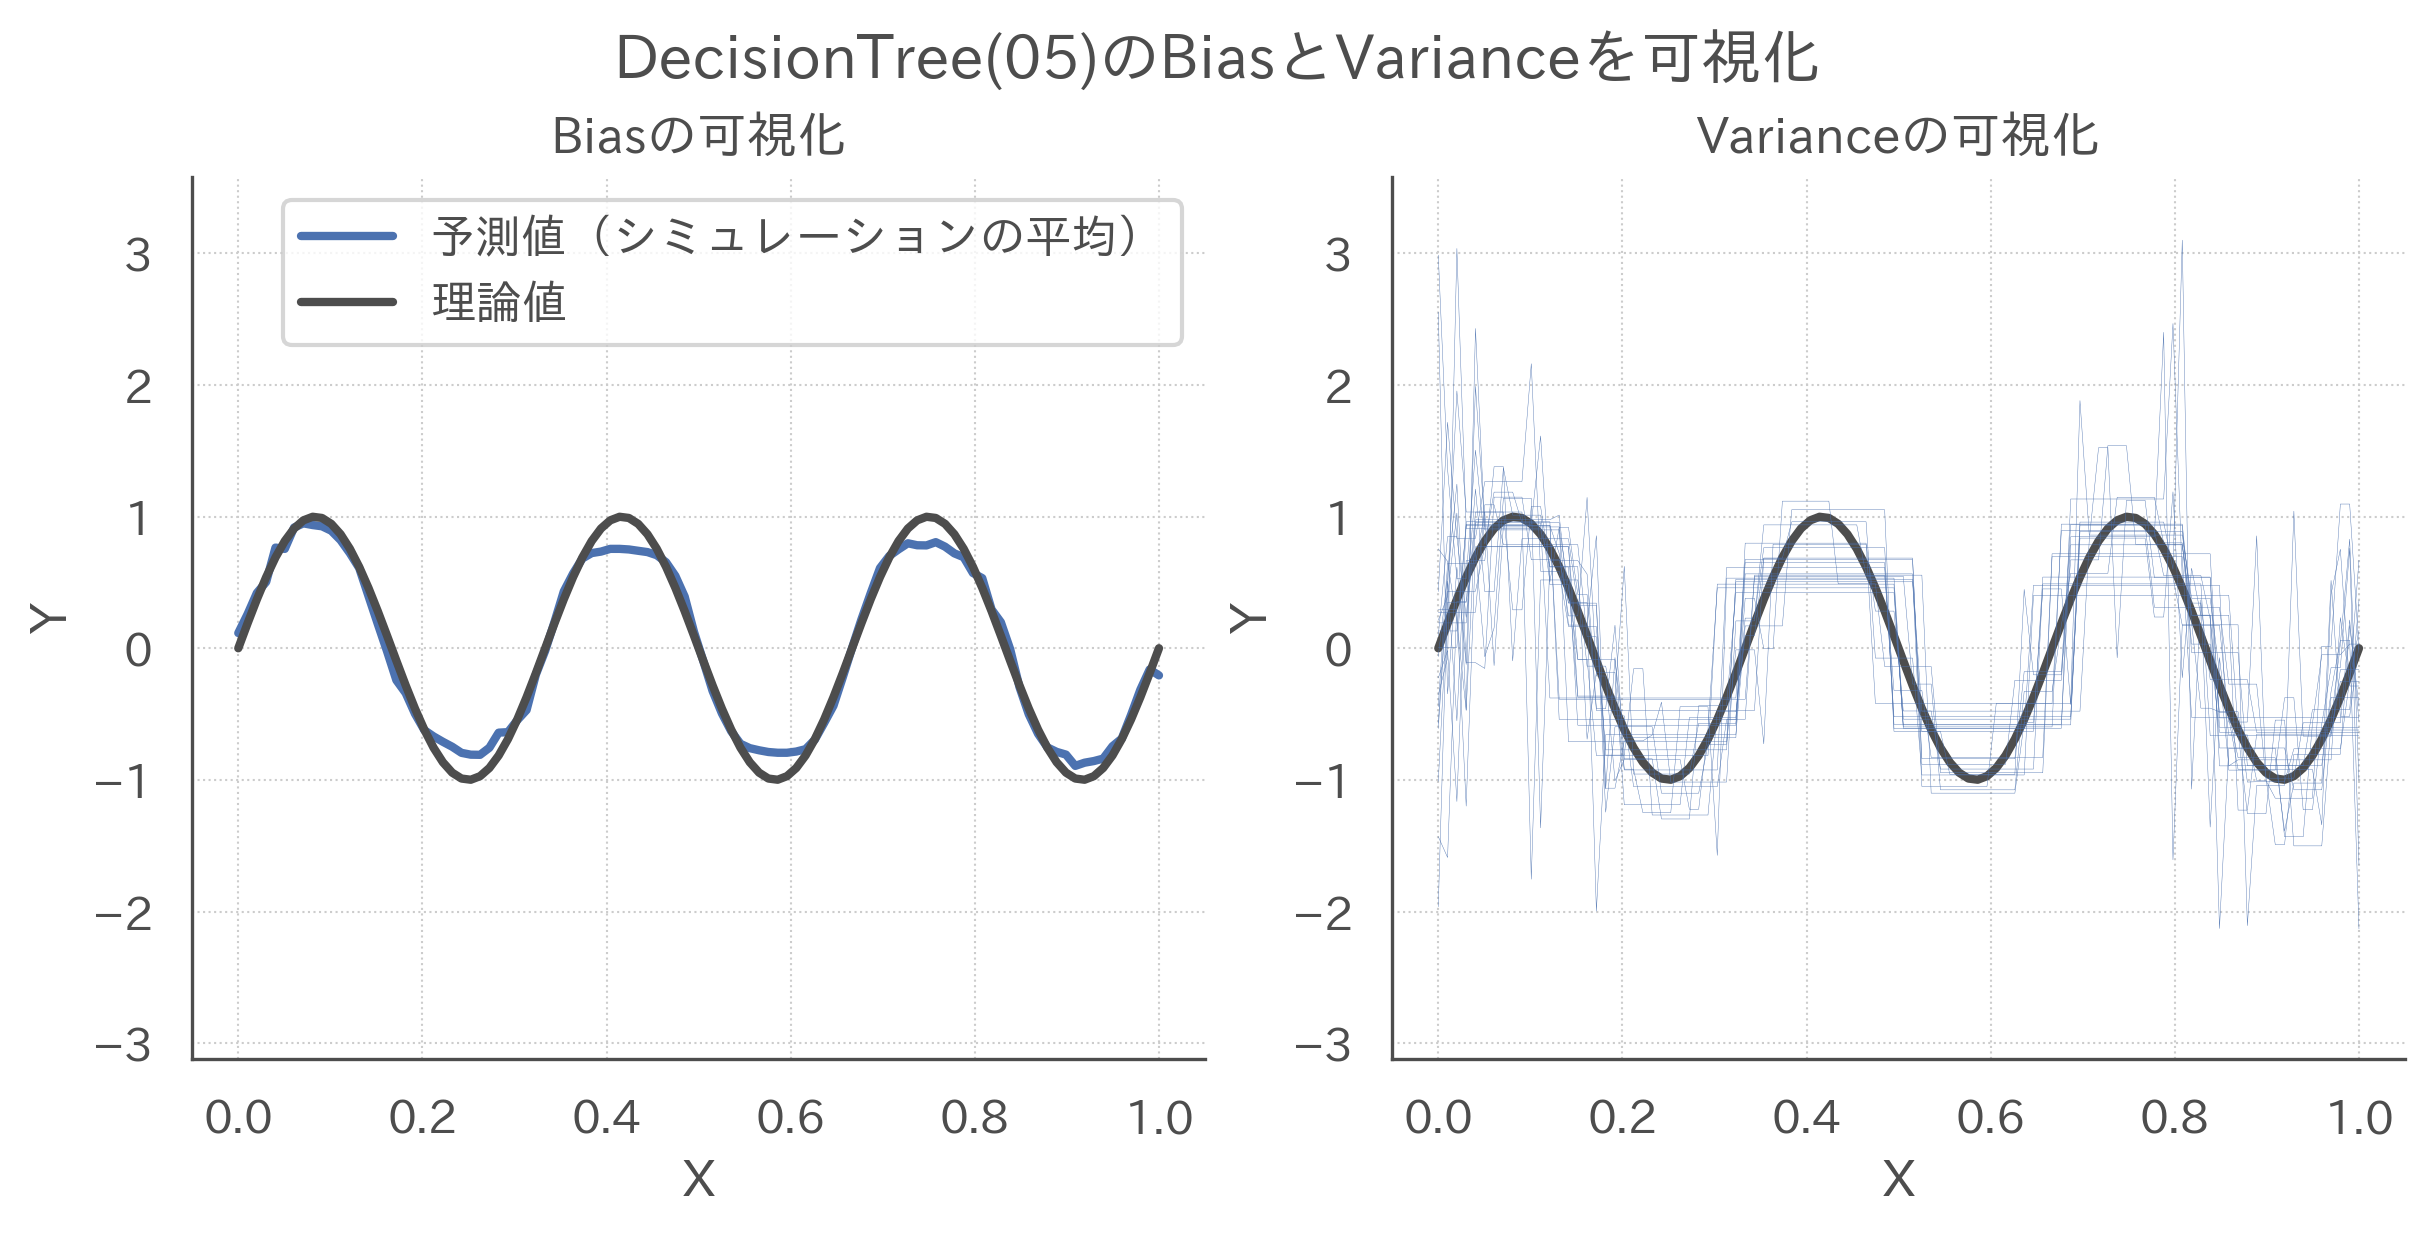

In [12]:
# 決定木の予測結果を可視化
simulator.draw_prediction(y_preds=y_preds, simulation_ids=range(20), estimator_key='DecisionTree(05)')

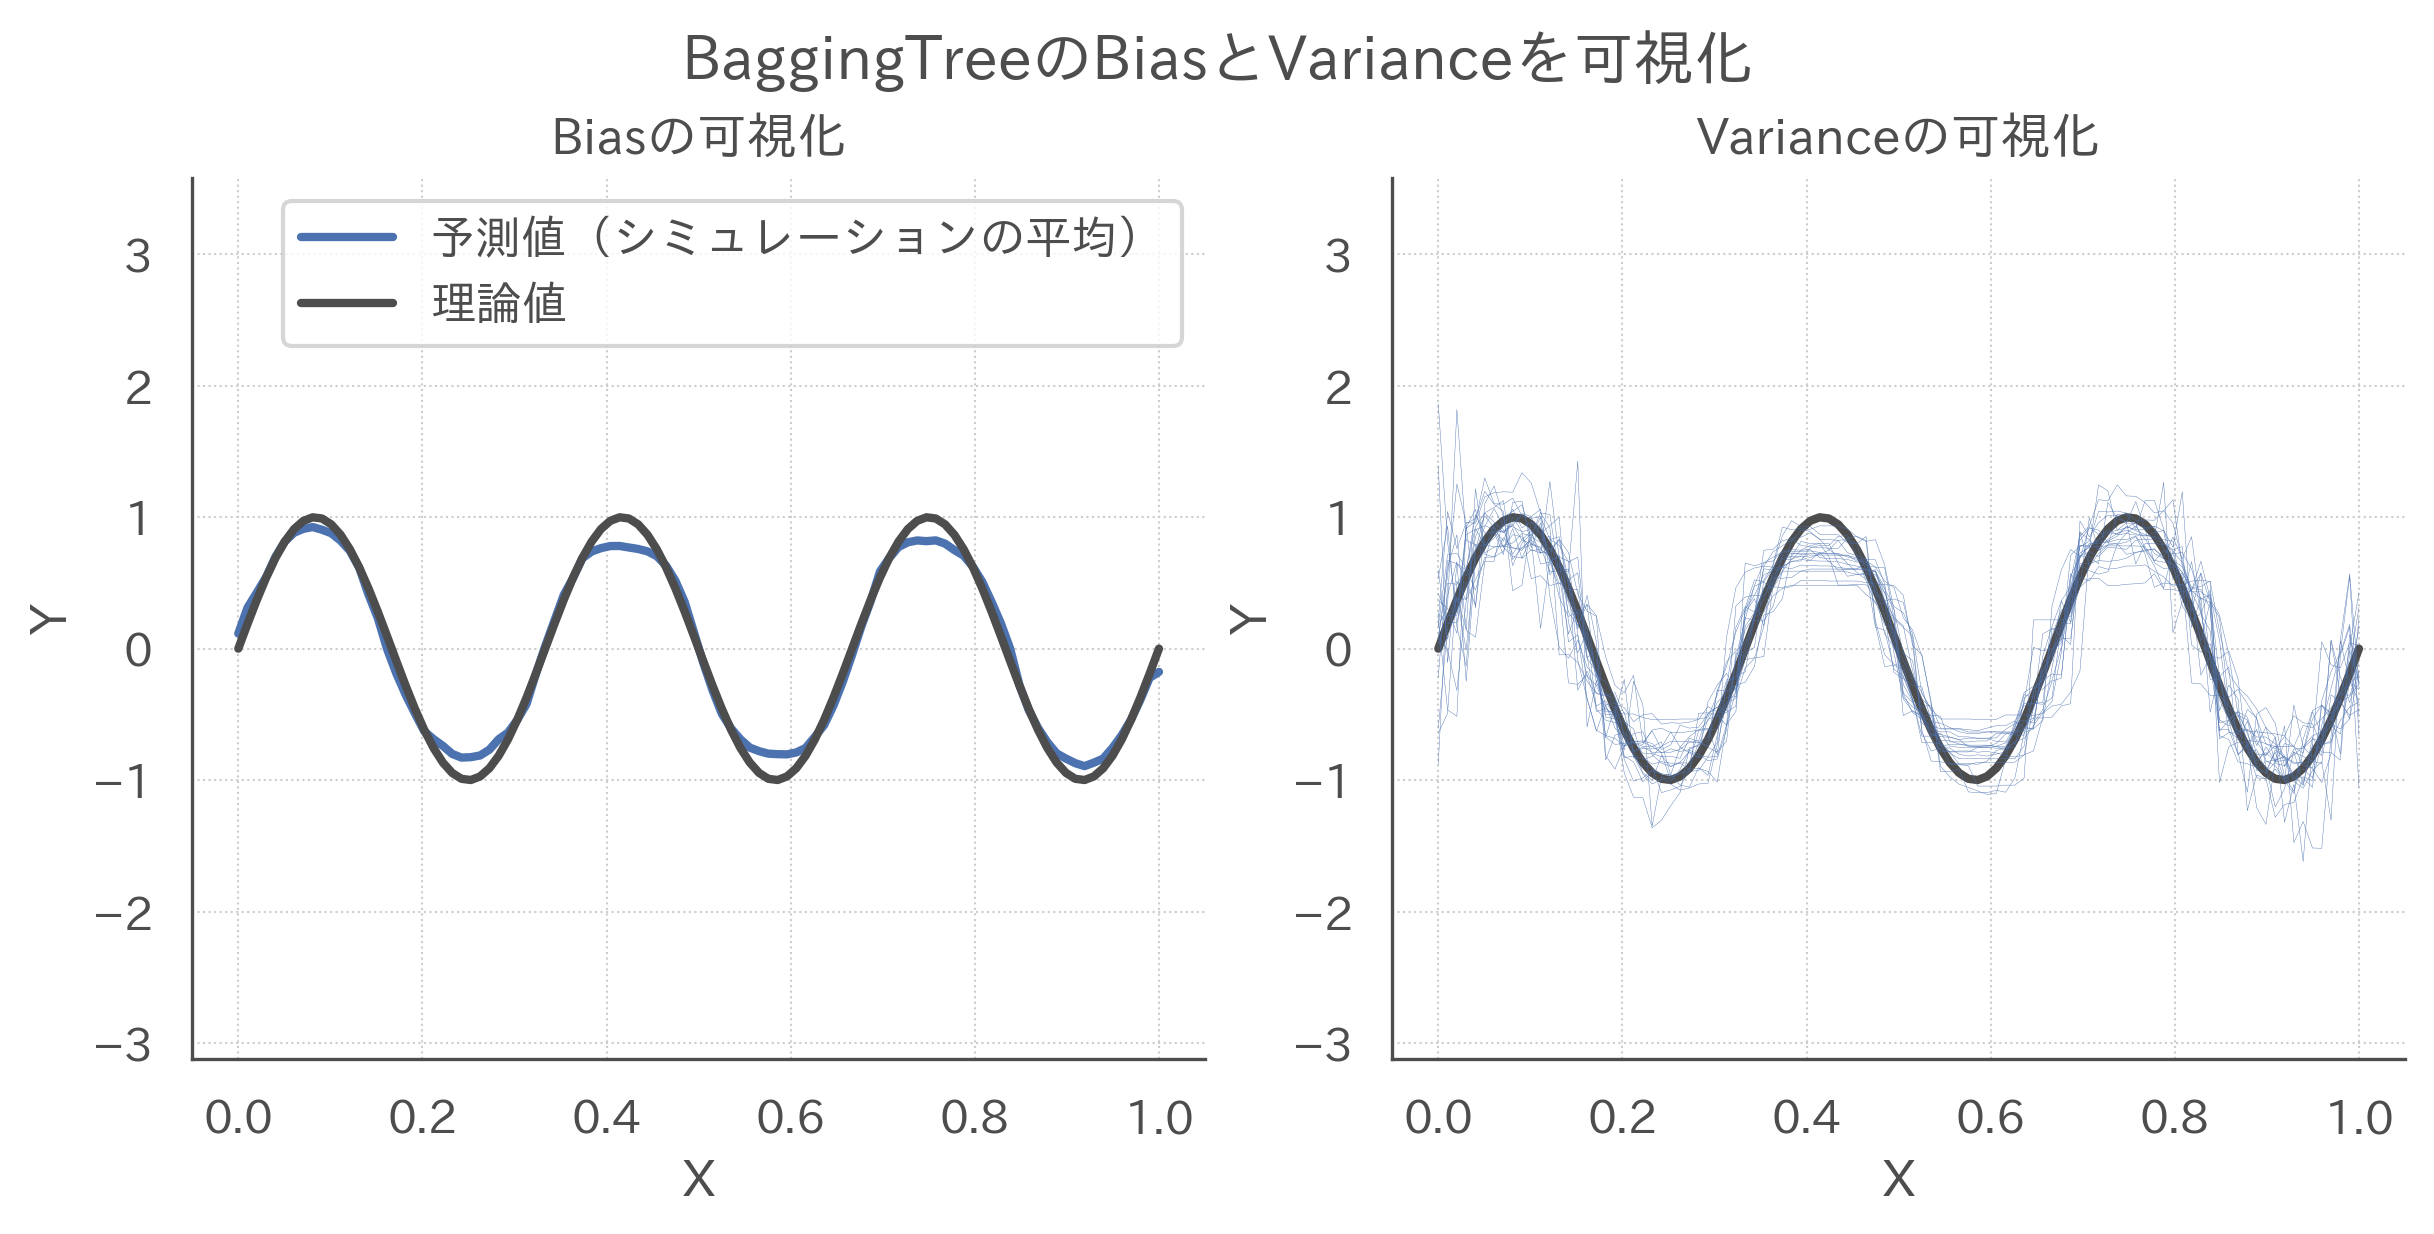

In [13]:
# バギングの予測結果を可視化
simulator.draw_prediction(y_preds=y_preds, simulation_ids=range(20), estimator_key='BaggingTree')

実際、単純な決定木とバギングの結果を直接比較すると、バリアンスが三分の一程度に抑えられていることがわかります。
モデルのアンサンブルによるバリアンスの改善をシミュレーションからも確認することができました。

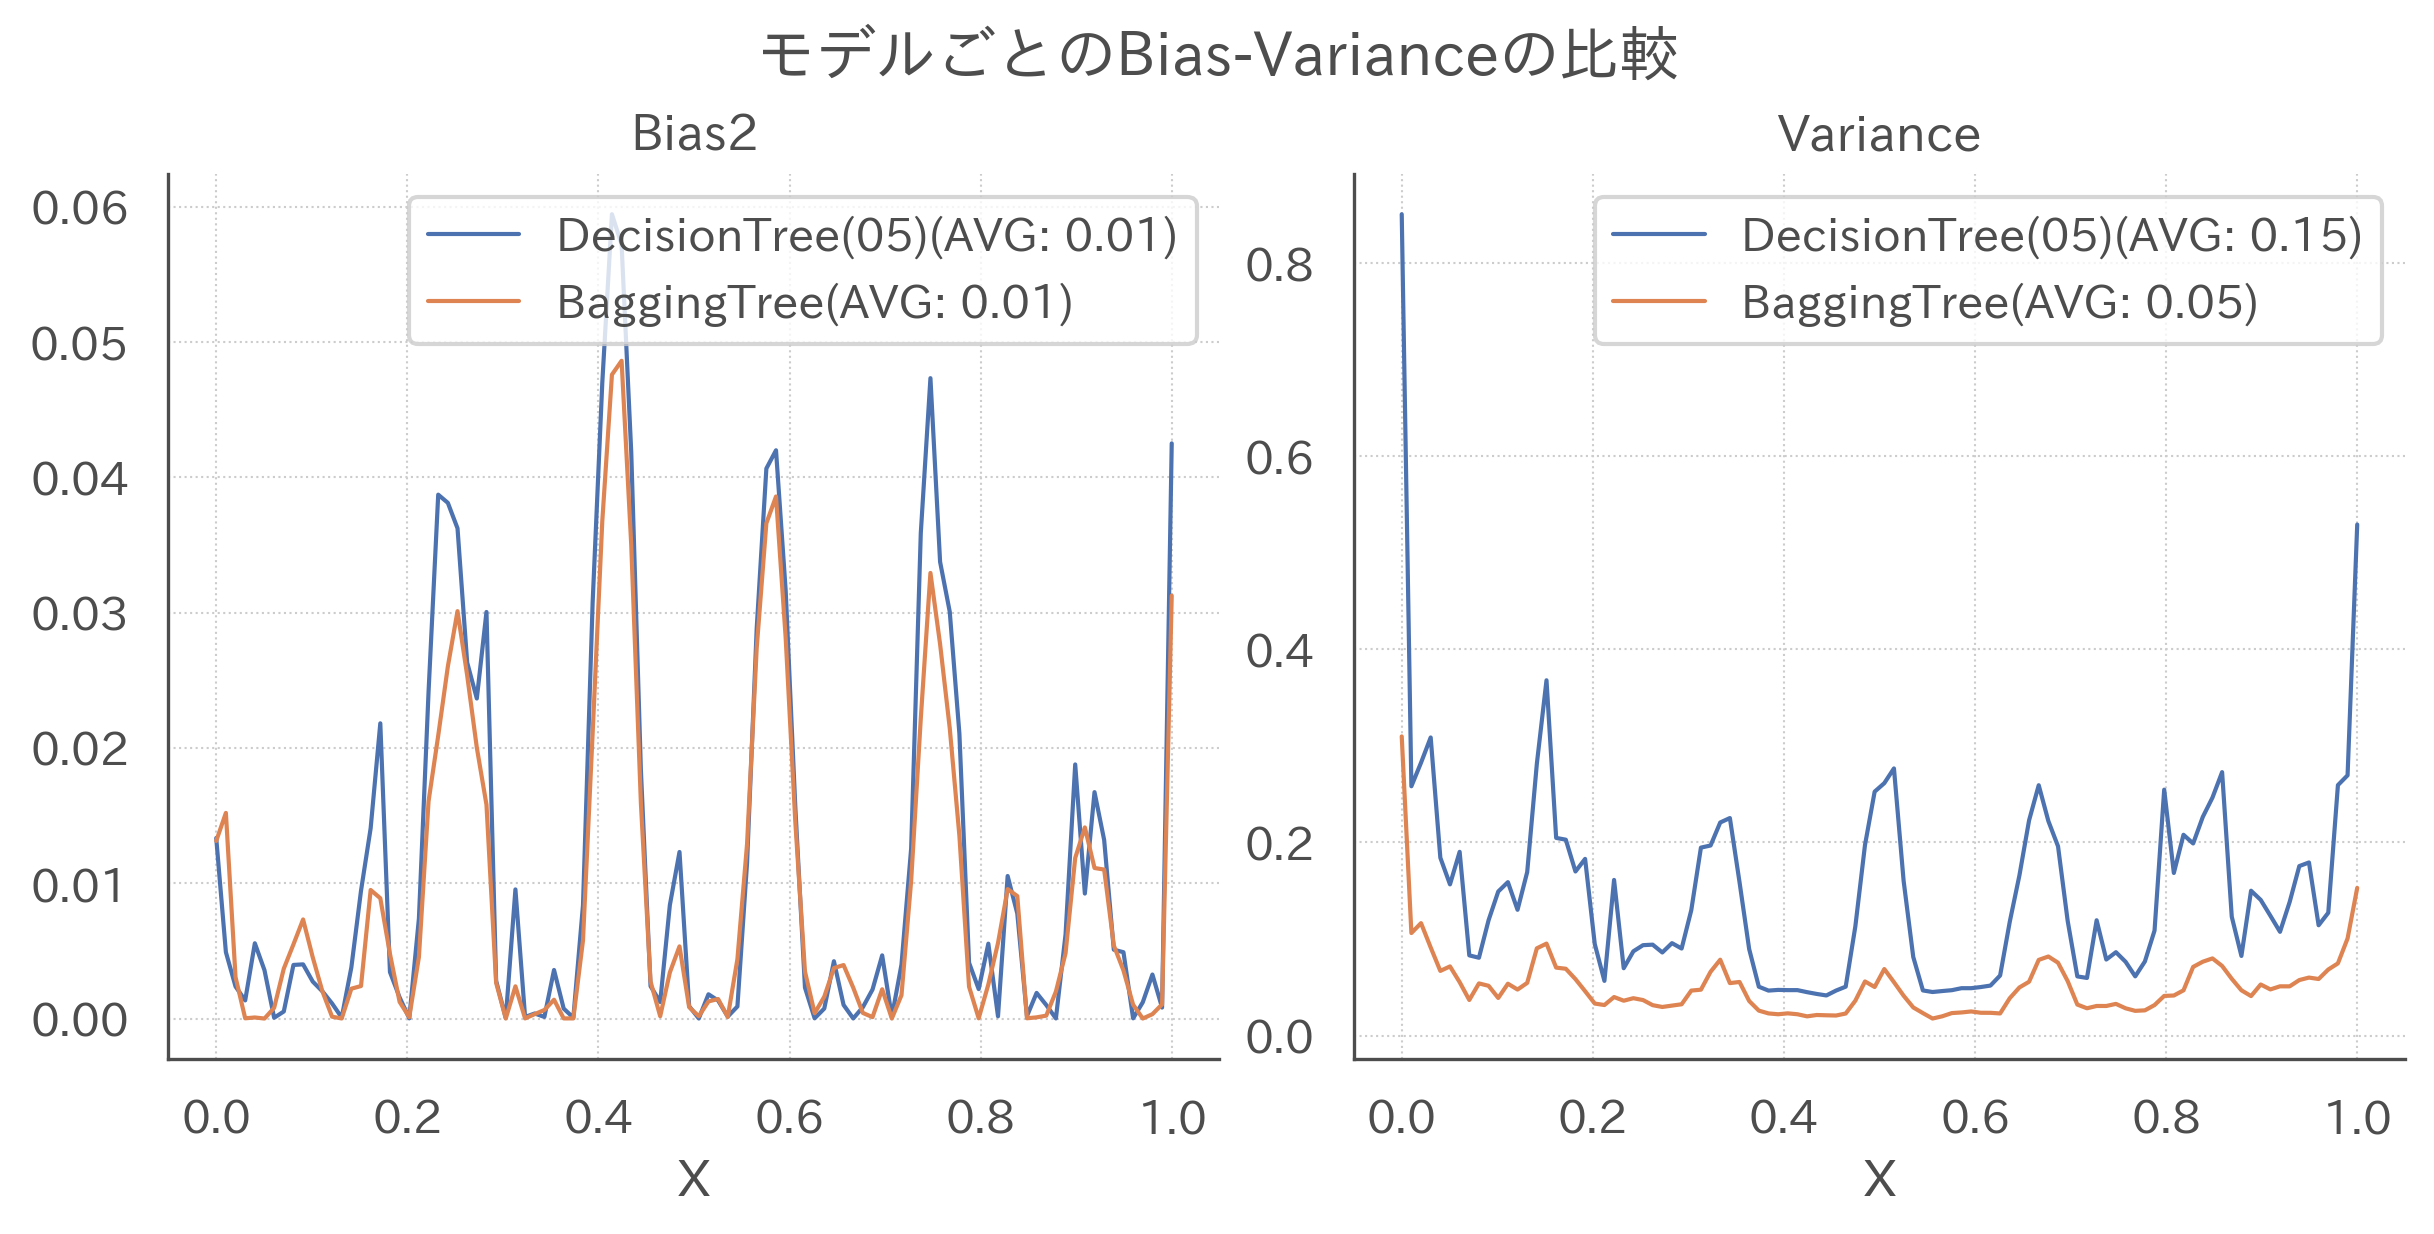

In [14]:
# 決定木とバギングでバイアスとバリアンスを比較
simulator.draw_bias_variance(bias_variances)

# まとめ

この記事では、バイアスとバリアンスの分解について、理論とシミュレーションの両面から確認しました。

- モデルの予測精度を表すMSEは、バイアスとバリアンスに分解できる
- バイアスとバリアンスにはトレードオフがある。モデルが単純だとバイアスが大きいがバリアンスは小さく、モデルが複雑だとバイアスが小さいがバリアンスは大きい
- モデルのアンサンブルはバリアンスを減少させることを通じて予測精度を改善することができる。モデル同士の相関が小さいほどアンサンブルの効果が高い


この記事で利用したシミュレーションコードは以下になります。

https://github.com/dropout009/bias_variance

# 参考文献

- Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. The elements of statistical learning. Vol. 1. No. 10. New York: Springer series in statistics, 2001.